In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [28]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import initializers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing import image

In [29]:
## !unzip -d train "Star Wars".zip

In [47]:
import time
from tqdm import tqdm

train_dir = 'train/'
filepaths = []
labels = []
images = []

folds = os.listdir(train_dir)

# Створення прогрес-бару
for fold in tqdm(folds, desc="Обробка папок"):
    foldpath = os.path.join(train_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)
        img = image.load_img(foldpath + '/' + file, target_size=(64, 64))
        images.append(image.img_to_array(img))

images = np.array(images)

# Об'єднання даних у DataFrame
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
train_df = pd.concat([Fseries, Lseries], axis=1)

print("Обробка завершена!")

Обробка папок: 100%|██████████| 51/51 [00:47<00:00,  1.07it/s]

Обробка завершена!


In [48]:
train_df

,filepaths,labels
0,train/Wicket W. Warrick/image_20211118_162043_...,Wicket W. Warrick
1,train/Wicket W. Warrick/image_20211118_161749_...,Wicket W. Warrick
2,train/Wicket W. Warrick/image_20211118_162041.gif,Wicket W. Warrick
3,train/Wicket W. Warrick/image_20211118_162318_...,Wicket W. Warrick
4,train/Wicket W. Warrick/image_20211118_162041_...,Wicket W. Warrick
...,...,...
4722,train/Bail Organa/image_20211118_162407_2837.jpg,Bail Organa
4723,train/Bail Organa/image_20211118_162407_2841.png,Bail Organa
4724,train/Bail Organa/image_20211118_162409_2851.jpg,Bail Organa
4725,train/Bail Organa/image_20211118_162153_1823.jpg,Bail Organa


<ipython-input-49-3dc18dc8df0a>:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  j = int(np.random.randint(0,images.shape[0],1))


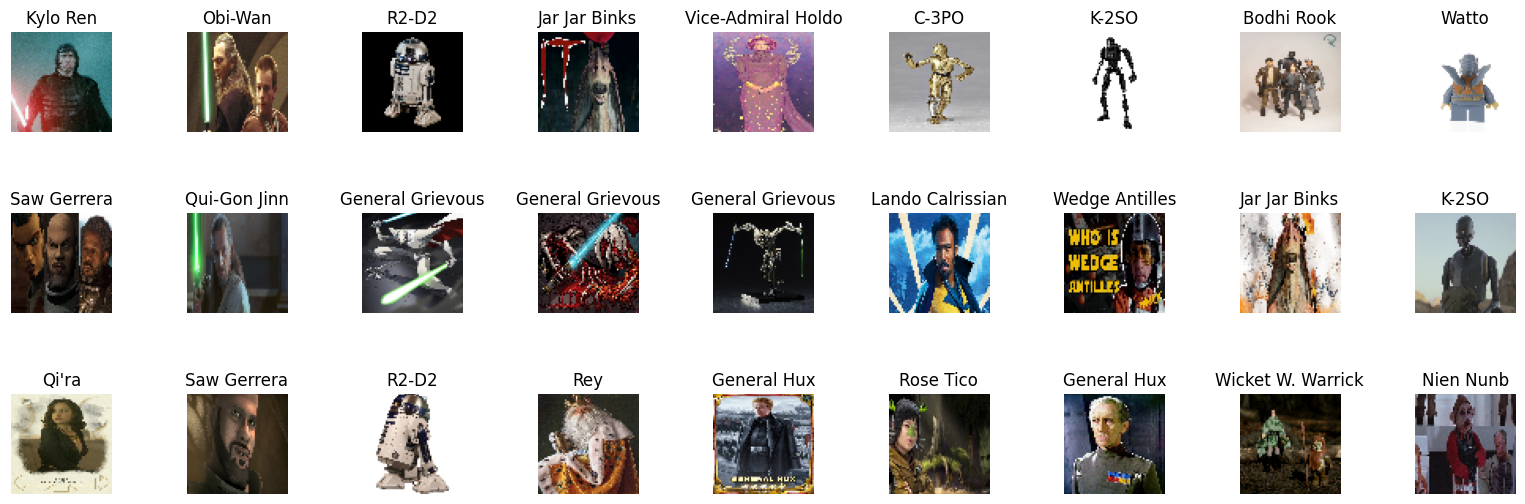

In [49]:
plt.figure(figsize=(20, 6))
plt.rcParams['font.size'] = 10
for i in range(27):
    plt.subplot(3,9,i+1)
    plt.axis('off')
    j = int(np.random.randint(0,images.shape[0],1))
    plt.imshow(images[j]/255)
    plt.title(train_df.labels[j])
    plt.subplots_adjust(hspace=.8)

In [50]:
train_df.labels.value_counts()[:20]

,count
labels,
Admiral Ackbar,100
Greedo,99
Luke Skywalker,98
Princess Leia Organa,98
Wedge Antilles,97
C-3PO,97
Rey,97
Jar Jar Binks,96
Kenobi,96


In [51]:
X_train = [images[i] for i in np.where(train_df.labels=='BB-8')][0]

In [52]:
X_train.shape

(91, 64, 64, 3)

In [53]:
input_dim = 64*64*3
X_train = X_train.reshape(X_train.shape[0], input_dim)
print('input shape: ', X_train.shape[1])
X_train = (X_train.astype(np.float32) - 127.5) / 127.5  # normilization [-1, 1]

input shape:  12288


In [54]:
X_train.shape

(91, 12288)

In [55]:
def build_discriminator():
    model =  keras.Sequential()
    model.add(layers.Dense(512*2, input_dim=input_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.1))

    model.add(layers.Dense(256*2))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(128*2))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

In [56]:
latent_dim = 100

def build_generator():
    model =  keras.Sequential()
    model.add(layers.Dense(128*2, input_dim=latent_dim, kernel_initializer=initializers.RandomNormal(stddev=0.01)))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Dense(256*2))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Dense(512*2))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Dense(input_dim, activation='tanh'))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

In [57]:
discriminator = build_discriminator()
generator = build_generator()

# Combined network
discriminator.trainable = False
gan_input = keras.Input(shape=(latent_dim,))
x = generator(gan_input)
gan_output = discriminator(x)
gan = keras.Model(inputs=gan_input, outputs=gan_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [58]:
def plot_generated_images(epoch, generator):
    num_of_images = 5
    noise = np.random.normal(0, 1, size=[num_of_images, latent_dim])
    generated_images=generator.predict(noise,verbose=0).reshape(num_of_images, 64,64,3)
    plt.figure()
    for i in range(num_of_images):
        plt.subplot(1, 5, i+1)
        plt.imshow((generated_images[i]/2+0.5))
        plt.axis('off')
        plt.tight_layout()
    plt.show()

In [59]:
discrim_losses = []
generator_losses = []

def train_model(epochs, batch_size):
    d_loss = 0
    gan_loss=0
    num_batches = int(X_train.shape[0]/batch_size)
    for ep in range(epochs+1):
        for i in range(num_batches):
            noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
            image_batch = X_train[np.random.randint(0, X_train.shape[0], size=batch_size)]

             # Generate fake MNIST images
            generated_images = generator.predict(noise,verbose=0)
            X = np.concatenate([image_batch, generated_images])

            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            y_dis[:batch_size] = 0.9  # (instead of 1.0) sort of trick in GAN training, so called label smoothing
            # Train discriminator
            discriminator.trainable = True
            d_loss = discriminator.train_on_batch(X, y_dis)
            discrim_losses.append(d_loss)

            # Train generator
            noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan_loss = gan.train_on_batch(noise, y_gen)
            generator_losses.append(gan_loss)

        if ep % 100 == 0:
            print('epoch: ', ep)
            print(ep, "discriminator loss: ", d_loss,"generator loss: ", gan_loss)
            plot_generated_images(ep, generator)

In [60]:
discriminator.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                     │ (None, 1024)                │      12,583,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_12 (LeakyReLU)           │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_13 (LeakyReLU)           │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_14 (LeakyReLU)           │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,240,321 (50.51 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 13,240,321 (50.51 MB)

In [61]:
generator.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                     │ (None, 256)                 │          25,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_15 (LeakyReLU)           │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_16 (LeakyReLU)           │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_17 (LeakyReLU)           │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 12288)               │      12,595,200 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,277,952 (50.65 MB)

 Trainable params: 13,277,952 (50.65 MB)

 Non-trainable params: 0 (0.00 B)

epoch:  0
0 discriminator loss:  1.6753811 generator loss:  [array(1.6753811, dtype=float32), array(1.6753811, dtype=float32), array(1.6753811, dtype=float32)]


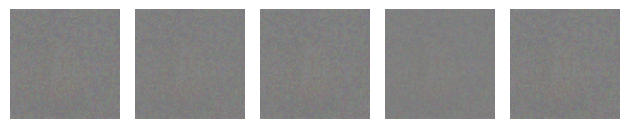

epoch:  100
100 discriminator loss:  0.9848341 generator loss:  [array(0.9848341, dtype=float32), array(0.9848341, dtype=float32), array(0.9848341, dtype=float32)]


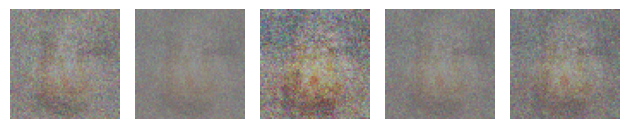

epoch:  200
200 discriminator loss:  0.8481512 generator loss:  [array(0.8481512, dtype=float32), array(0.8481512, dtype=float32), array(0.8481512, dtype=float32)]


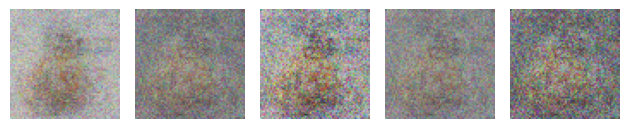

epoch:  300
300 discriminator loss:  0.79917485 generator loss:  [array(0.79917485, dtype=float32), array(0.79917485, dtype=float32), array(0.79917485, dtype=float32)]


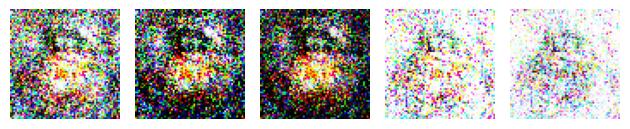

epoch:  400
400 discriminator loss:  0.6918099 generator loss:  [array(0.6918099, dtype=float32), array(0.6918099, dtype=float32), array(0.6918099, dtype=float32)]


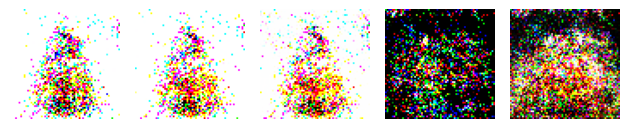

epoch:  500
500 discriminator loss:  0.5947004 generator loss:  [array(0.5947004, dtype=float32), array(0.5947004, dtype=float32), array(0.5947004, dtype=float32)]


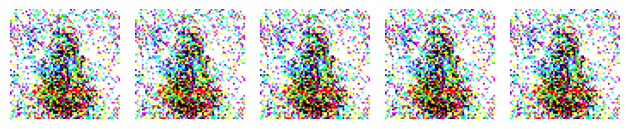

In [62]:
epochs = 500
batch_size = 32
train_model(epochs, batch_size)

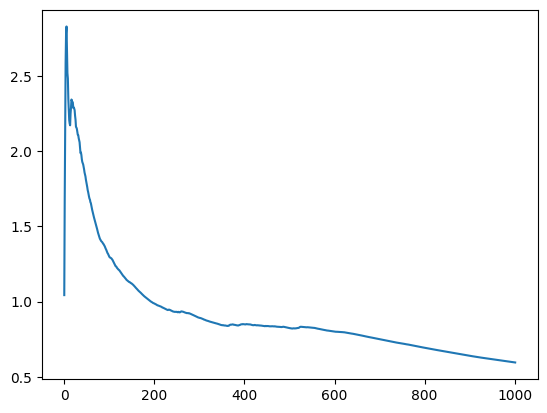

In [63]:

plt.plot(discrim_losses)